In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as skd
import sklearn.metrics as skm
from time import *
from tqdm import tqdm
def A_to_L(A):
    D=np.diag(np.sum(A,axis=0))
    return D-A

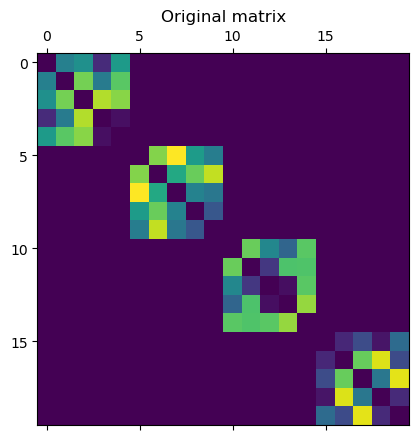

In [2]:
#First, we use the spectralGraphTopology to denoise laplacian matrices polluted with noise. 
# We generate a 4 components adjacency matrix



n_class_feats = 5
n_classes = 4
n_feats = n_classes * n_class_feats
prob_intra = 1
prob_extra = 0.3
max_weight_intra = 1
max_weight_extra = 0.3
adj = np.zeros((n_feats, n_feats))
for i in range(n_classes):
    i_start = i * n_class_feats
    i_end = i_start + n_class_feats
    for ii in range(i_start, i_end):
        for jj in range(ii+1, i_end):
            adj[ii, jj] = np.random.binomial(n=1, p=prob_intra) * np.random.uniform(high=max_weight_intra)
plt.matshow(adj+adj.T)
plt.title("Original matrix")
plt.show()

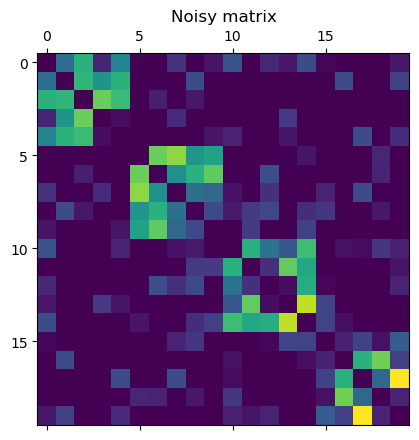

In [3]:
for i in range(n_feats):
    for j in range(i+1, n_feats):
        adj[i, j] += np.random.binomial(n=1, p=prob_extra) * np.random.uniform(high=max_weight_extra)
adj = adj + adj.T
plt.matshow(adj)
plt.title("Noisy matrix")
plt.show()

In [4]:
#helpers
import numpy as np
from sklearn.isotonic import *
from numba import njit

# Computes the Adjacency linear operator which maps a vector of weights into
# a valid Adjacency matrix.
# @param w weight vector of the graph
# @return Aw the Adjacency matrix
def Ad(v):#TODO check new version still works
    """take an p(p-1)//2 array and return the adjacency matrice"""
    p=1
    while (p*(p-1))//2!=v.shape[0]:
        p+=1
    a = np.zeros([p,p])
    s=0
    for nb in range(p-1,0,-1):
        i=p-1-nb
        a[i][i+1:]=v[s:s+p-i-1]
        """for j in range(i+1,p):
            a[i][j] = v[s+j-i-1]
            a[j][i] = v[s+j-i-1]"""
        s += nb
    a+=a.T
    return a

# Computes the Laplacian linear operator which maps a vector of weights into a valid Laplacian matrix.
# @param w weight vector of the graph
# @return Lw the Laplacian matrix
def La(v):
    a = -Ad(v)
    for k in range(a.shape[0]):
        a[k][k]=-np.sum(a[k])
    return a

@njit
def Lstar(M):
  """
  Compute the adjoint operator of L
  """
  N = M.shape[1]
  k = (N * (N - 1)) // 2
  j, l = 0, 1
  w = np.zeros(k)
  for i in np.arange(k):
    w[i] = M[j, j] + M[l, l] - (M[l, j] + M[j, l])
    if (l == (N - 1)):
        j += 1
        l = j + 1
    else:
      l += 1
  return w

#Computes the matrix form of the composition of the operators Lstar and
# L, i.e., Lstar o L.
#
# @param n number of columns/rows
# @return M the composition of Lstar and L
def Mmat(n):
  e = np.zeros(n)
  M = np.zeros([n, n])
  e[0] = 1
  M[0] = Lstar(La(e))
  for j in np.arange(1,n):
    e[j - 1] = 0
    e[j] = 1
    M[j] = Lstar(L(e))
  return M.T

@njit
def Astar(M):
  N = M.shape[1]
  k = (N * (N - 1))//2
  j = 0
  l = 1
  w=np.zeros(k)

  for i in np.arange(k):
    w[i] = M[l, j] + M[j, l]
    if l == (N - 1):
      j+=1
      l = j+1
    else:
      l+=1
  return w


# Computes the matrix form of the composition of the operators Astar and
# A, i.e., Astar o A.
def Pmat(n):
  e = np.zeros(n)
  M = np.zeros([n, n])
  e[0] = 1;
  M[0] = Astar(Ad(e))
  for j in np.arange(1,n):
    e[j - 1] = 0
    e[j] = 1
    M[j] = Astar(A(e))
  return M.T

def vec(M):
  return M.T.flatten()

def vecLmat(n):
  ncols = (n * (n - 1))//2
  nrows = n * n

  e = np.zeros(ncols)
  R = np.zeros([nrows,ncols])
  e[0] = 1;
  R[0] = vec(L(e));
  for j in np.arange(1,ncols):
    e[j - 1] = 0;
    e[j] = 1;
    R[j] = vec(L(e));
  return R.T




#Computes the inverse of the L operator.

# @param M Laplacian matrix
# @return w the weight vector of the graph
def Linv(M):
  n = M.shape[0]
  return np.concatenate([-M[i][i+1:] for i in np.arange(n)])

#get the n(n-1)//2 vector from the laplacian(or A?)
#M is laplacian
#w is weight vector
def Ainv(M):
  n = M.shape[0]
  return np.concatenate([M[i][i+1:] for i in np.arange(n)])


def isoreg(y):
    """
    Compute the isotonic regression of a vector y
    For compatibity reasons, we chosse an arbitrary x as training data
    but x is useless as we only keep the estimates of the y_i and never interpolate
    """
    x = np.arange(len(y))
    isoreg = IsotonicRegression()
    isoreg.fit(x, y)
    return isoreg.f_(x)



def w_init(w0, Sinv):
  """
  Initialize w0, the vectorized upper triangular coefficients of the adjacency matrix
  """
  if type(w0) is str:
    if (w0 == "qp"):
      R = vecLmat(Sinv.shape[1])
      qp = 0
      assert False,"idk"
      #quadprog::solve.QP(crossprod(R), t(R) %*% vec(Sinv), diag(ncol(R)))
      w0 = qp#qp$solution
    elif (w0 == "naive"):
      w0 = Linv(Sinv)
      w0[w0 < 0] = 0 # Should not happen
  return w0



def laplacian_w_update(w, Lw, U, beta, lambd, K, p):
  """
  Update w according to equation 38
  """
  t = lambd[:, None]**0.5 * U.T
  c = Lstar(t.T@t - K / beta)
  grad_f = Lstar(Lw) - c
  if 1:
    M_grad_f = - Lstar(La(grad_f))
    wT_M_grad_f = np.sum(w * M_grad_f)
    dwT_M_dw = np.sum(grad_f * M_grad_f)
  # exact line search
    t = (wT_M_grad_f - np.sum(c * grad_f)) / dwT_M_dw
  else:
      t=1/(2*p)
  w_update = w - t * grad_f
  w_update[w_update < 0] = 0
  return w_update



def joint_w_update(w, Lw, Aw, U, V, lambd, psi, beta, nu, K):
  t=lambd[:, None]**0.5*U.T
  ULmdUT = t.T@t
  VPsiVT = V @ np.diag(psi) @ V.T
  c1 = Lstar(beta * ULmdUT - K)
  c2 = nu * Astar(VPsiVT)
  Mw = Lstar(Lw)
  Pw = 2 * w
  grad_f1 = beta * Mw - c1
  M_grad_f1 = Lstar(La(grad_f1))
  grad_f2 = nu * Pw - c2
  P_grad_f2 = 2 * grad_f2
  grad_f = grad_f1 + grad_f2
  t = np.sum((beta * Mw + nu * Pw - (c1 + c2)) * grad_f) / np.sum(grad_f * (beta * M_grad_f1 + nu * P_grad_f2))
  w_update = w - t * (grad_f1 + grad_f2)
  w_update[w_update < 0] = 0
  return w_update


def bipartite_w_update(w, Aw, V, nu, psi, K, J, Lips):
  reg_eps = 0
  grad_h = 2 * w - Astar(V @ np.diag(psi) @ V.T) #+ Lstar(K) / beta#
  w_update = w - (Lstar(np.linalg.inv(La(w) + J+np.eye(J.shape[0])*reg_eps) + K) + nu * grad_h) / (2 * nu + Lips)
  w_update[w_update < 0] = 0#TODO faire en sorte que la régularisation ligne précédent ne soit pas nécessaire
  return w_update



def laplacian_U_update(Lw, k):
  """
  Return all but the k first eigenvectors of the Laplacian Lw
  """
  return np.linalg.eigh(Lw)[1][:, k:]


def bipartite_V_update(Aw, z):
  n = Aw.shape[1]
  V = np.linalg.eigh(Aw)[1]
  return np.concatenate([V[:, :(n - z)//2], V[:,(n + z)//2:n]],axis=1)


def joint_U_update(Lw,k):
  return np.linalg.eigh(Lw)[1][:, k:]


def joint_V_update(Aw,z):
  return bipartite_V_update(Aw,z)



def laplacian_lambda_update(lb, ub, beta, U, Lw, k):
  """
  Update lambda according to algorithm 1
  """
  q = Lw.shape[1] - k
  d = np.diagonal(U.T @ Lw @ U)
  # unconstrained solution as initial point
  lambd = .5 * (d + (d**2 + 4 / beta)**0.5)
  eps = 1e-9
  condition_ub = np.array([(lambd[q-1] - ub) <= eps])
  condition_lb = np.array([(lambd[0] - lb) >= -eps])
  condition_ordered = (lambd[1:q] - lambd[0:(q-1)]) >= -eps
  condition = np.concatenate([condition_ub,\
                 condition_lb,\
                 condition_ordered])
  if np.all(condition):
    return lambd
  else:
    greater_ub = lambd > ub
    lesser_lb = lambd < lb
    lambd[greater_ub] = ub
    lambd[lesser_lb] = lb
  condition_ub = np.array([(lambd[q-1] - ub) <= eps])
  condition_lb = np.array([(lambd[0] - lb) >= -eps])
  condition_ordered = (lambd[1:q] - lambd[:(q-1)]) >= -eps
  condition = np.concatenate([condition_ub,\
                 condition_lb,\
                 condition_ordered])
  if np.all(condition):
    return (lambd)
  else:
    print(lambd)
    raise ValueError('eigenvalues are not in increasing order consider increasing the value of beta')


def bipartite_psi_update(V, Aw, lb = -np.inf, ub = np.inf):
  c = np.diagonal(V.T @ Aw @ V)
  n = c.shape[0]
  c_tilde = .5 * (c[(n//2):][::-1] - c[:(n//2)])
  x = isoreg(c_tilde[::-1])
  #x <- stats::isoreg(rev(c_tilde))$yf # R
  x = np.concatenate((-x[::-1], x))
  #x <- c(-rev(x), x) # R
  x[x < lb] = lb
  x[x > ub] = ub
  return x


def Ad(v):#TODO check new version still works
    """take an p(p-1)//2 array and return the adjacency matrice"""
    p=1
    while (p*(p-1))//2!=v.shape[0]:
        p+=1
    a = np.zeros([p,p])
    s=0
    for nb in range(p-1,0,-1):
        i=p-1-nb
        a[i][i+1:]=v[s:s+p-i-1]
        """for j in range(i+1,p):
            a[i][j] = v[s+j-i-1]
            a[j][i] = v[s+j-i-1]"""
        s += nb
    a+=a.T
    return a


def La(v):
    a = -Ad(v)
    for k in range(a.shape[0]):
        a[k][k]=-np.sum(a[k])
    return a


def Linv(M):
  n = M.shape[0]
  return np.concatenate([-M[i][i+1:] for i in np.arange(n)])

#get the n(n-1)//2 vector from the laplacian(or A?)
#M is laplacian
#w is weight vector
def Ainv(M):
  n = M.shape[0]
  return np.concatenate([M[i][i+1:] for i in np.arange(n)])



def w_init(w0, Sinv):
  """
  Initialize w0, the vectorized upper triangular coefficients of the adjacency matrix
  """
  if type(w0) is str:
    if (w0 == "qp"):
      R = vecLmat(Sinv.shape[1])
      qp = 0
      assert False,"idk"
      #quadprog::solve.QP(crossprod(R), t(R) %*% vec(Sinv), diag(ncol(R)))
      w0 = qp#qp$solution
    elif (w0 == "naive"):
      w0 = Linv(Sinv)
      w0[w0 < 0] = 0 # Should not happen
  return w0


def pairwise_matrix_rownorm(M):
    """
    Compute the matrix E where Eij is ||x_i - x_j||**2
    """
    n = M.shape[0]
    V = np.zeros([n, n])
    for i in range(n):
        for j in range(i+1, n):
            V[i][j]=np.linalg.norm(M[i]-M[j])**2
    V+=V.T
    return V
def build_initial_graph(Y, m):
    # if well understood create the m nearest neighboor directed graph
    n = Y.shape[0]
    A = np.zeros([n, n])
    E = pairwise_matrix_rownorm(Y)
    for i in np.arange(0, n):
        sorted_index = np.argsort(E[i])
        j_sweep = sorted_index[1:m+1]
        den = m * E[i][sorted_index[m+1]] - np.sum(E[i][j_sweep]) # renormalization, but why is it like that?
        ei = E[i, sorted_index[m+1]]
        for j in j_sweep:
            A[i,j] = (ei - E[i, j]) / den
    return A

In [5]:
def learn_k_component_graph (S, is_data_matrix = False, k = 1, w0 = "naive", lb = 0, ub = 1e4, alpha = 0,\
                                    beta = 1e4, beta_max = 1e6, fix_beta = True, rho = 1e-2, m = 7,\
                                    maxiter = 1e4, abstol = 1e-6, reltol = 1e-4, eigtol = 1e-9,\
                                    record_objective = False, record_weights = False, verbose = True):
  """
  Learn the Laplacian and adjacency matrix corresponding to a k-component graph
  Params:
    S: Either the original correlation matrix or the raw data matrix
    is_data_matrix: bool, if True then the correlations matrix is computed from S
    k: number of components of the final graph
    m: number of neighbors considered to build the matrix (only useful if is_data_matrix is true)
  """
  if (is_data_matrix or S.shape[0] != S.shape[1]):
    A = build_initial_graph(S, m = m)
    D = np.diag(.5 * (np.sum(A,axis=1) + np.sum(A,axis=0)))
    L = D - .5 * (A + A.T)
    S = np.linalg.pinv(L)
    is_data_matrix = True
  # number of nodes
  n = S.shape[0]
  # l1-norm penalty factor
  H = alpha * (2 *np.eye(n) - np.ones([n, n]))
  K = S + H
  # find an appropriate inital guess
  if (is_data_matrix):
    Sinv = L
  else:
    Sinv = np.linalg.pinv(S)
  # if w0 is either "naive" or "qp", compute it, else return w0
  w0 = w_init(w0, Sinv)
  # compute quantities on the initial guess
  Lw0 = La(w0)
  U0 = laplacian_U_update(Lw = Lw0, k = k)
  lambda0 = laplacian_lambda_update(lb = lb, ub = ub, beta = beta, U = U0,\
                                     Lw = Lw0, k = k)

  beta_seq = [beta]
  time_seq = [0]
  start_time = time()
  for i in tqdm(range(maxiter)):
    #test_time = time()
    #test_total_time = time()
    w = laplacian_w_update(w = w0, Lw = Lw0, U = U0, beta = beta,\
                            lambd = lambda0, K = K, p=S.shape[0])
    #test_laplacian_w_update_time= time() - test_time
    #test_time = time()
    Lw = La(w)
    #test_La_time = time() - test_time
    #test_time = time()
    U = laplacian_U_update(Lw = Lw, k = k)
    #test_laplacian_U_update_time = time() - test_time
    #test_time = time()
    lambd = laplacian_lambda_update(lb = lb, ub = ub, beta = beta, U = U,\
                                      Lw = Lw, k = k)
    #test_laplacian_lambda_update_time = time() - test_time
    #test_time = time()
    # check for convergence
    werr = abs(w0 - w)
    has_w_converged = (np.all(werr <= .5 * reltol * (w + w0)) or np.all(werr <= abstol))
    time_seq.append(time()-start_time)
    if not(fix_beta):
      eigvals=np.linalg.eigh(Lw)[0]
      n_zero_eigenvalues = np.sum(abs(eigvals) < eigtol)
      if (k <= n_zero_eigenvalues):
        beta = (1 + rho) * beta
      elif (k > n_zero_eigenvalues):
        beta = beta / (1 + rho)
      if (beta > beta_max):
        beta = beta_max
      beta_seq.append(beta)
    if has_w_converged:
      break
    # update estimates
    w0 = w
    U0 = U
    lambda0 = lambd
    Lw0 = Lw
    """
    test_convergence_time = time() - test_time
    test_total_time = time() - test_total_time
    print('total time', test_total_time)
    print('total ratio (1):', (test_laplacian_w_update_time + test_La_time + test_laplacian_U_update_time + test_laplacian_lambda_update_time + test_convergence_time)/test_total_time)
    print('laplacian_w_update', test_laplacian_w_update_time/test_total_time*100)
    print('La', test_La_time/test_total_time*100)
    print('laplacian_U_update', test_laplacian_U_update_time/test_total_time*100)
    print('laplacian_lambda_update', test_laplacian_lambda_update_time/test_total_time*100)
    print('convergence', test_convergence_time/test_total_time*100)"""
  # compute the adjacency matrix
  Aw = Ad(w)
  results = {"Laplacian" : Lw, "Adjacency" : Aw, "w" : w, "lambd" : lambd, "U" : U,\
                 "elapsed_time" : time_seq, "convergence" : has_w_converged,\
                  "beta_seq" : beta_seq}
  return results

def learn_cospectral_graph(S, lambd, k = 1, is_data_matrix = False, w0 = "naive", alpha = 0,\
                                   beta = 1e4, beta_max = 1e6, fix_beta = True, rho = 1e-2, m = 7,\
                                   maxiter = 1e4, abstol = 1e-6, reltol = 1e-4, eigtol = 1e-9,\
                                   record_objective = False, record_weights = False, verbose = True):
  if (is_data_matrix or S.shape[0] != S.shape[1]):
    A = build_initial_graph(S, m = m)
    D = np.diag(.5 * (np.sum(A,axis=1) + np.sum(A,axis=0)))
    L = D - .5 * (A + A.T)
    S = np.linalg.pinv(L)
    is_data_matrix = True
  # number of nodes
  n = S.shape[0]
  # l1-norm penalty factor
  H = alpha * (2 * np.eye(n)- np.ones(n, n))
  K = S + H
  # find an appropriate inital guess
  if (is_data_matrix):
    Sinv = L
  else:
    Sinv = np.linalg.pinv(S)
  # if w0 is either "naive" or "qp", compute it, else return w0
  w0 = w_init(w0, Sinv)
  # compute quantities on the initial guess
  Lw0 = La(w0)
  U0 = laplacian_U_update(Lw = Lw0, k = k)
  beta_seq = [beta]
  time_seq = [0]
  start_time = time()
  for i in np.arange(maxiter):
    w = laplacian_w_update(w = w0, Lw = Lw0, U = U0, beta = beta,\
                            lambd = lambd, K = K)
    Lw = La(w)
    U = laplacian_U_update(Lw = Lw, k = k)
    # check for convergence
    werr = abs(w0 - w)
    has_w_converged = min(werr <= .5 * reltol * (w + w0)) or min(werr <= abstol)
    time_seq.append(time() - start_time)
    if not(fix_beta):
      eigvals = np.linalg.eigh(Lw)[0]
      n_zero_eigenvalues = np.sum(abs(eigvals) < eigtol)
      if (k <= n_zero_eigenvalues):
        beta = (1 + rho) * beta
      elif (k > n_zero_eigenvalues):
        beta = beta / (1 + rho)
      if (beta > beta_max):
        beta = beta_max
      beta_seq.append(beta)
    if (has_w_converged):
      break
    # update estimates
    w0 = w
    U0 = U
    Lw0 = Lw
  # compute the adjacency matrix
  Aw = Ad(w)
  results = {"Laplacian" : Lw, "Adjacency" : Aw, "w" : w, "lambd" : lambd, "U" : U,\
                  "elapsed_time" : time_seq, "convergence" : has_w_converged,\
                  "beta_seq" : beta_seq}
  return results

def learn_bipartite_graph(S, is_data_matrix = False, z = 0, nu = 1e4, alpha = 0.,
                                  w0 = "naive", m = 7, maxiter = 1e4, abstol = 1e-6, reltol = 1e-4,
                                  record_weights = False, verbose = True):
  if is_data_matrix or S.shape[0] != S.shape[1]:
    A = build_initial_graph(S, m = m)
    D =  np.diag(.5 * (np.sum(A,axis=1) + np.sum(A,axis=0)))
    L = D - .5 * (A + A.T)
    S = np.linalg.pinv(L)
    is_data_matrix = True
  # number of nodes
  n = S.shape[0]
  # note now that S is always some sort of similarity matrix
  J = np.ones([n,n])/n
  # l1-norm penalty factor
  H = alpha * (2 * np.eye(n) - np.ones([n, n]))
  K = S + H
  # compute initial guess
  if is_data_matrix:
    Sinv = L
  else:
    Sinv = np.linalg.pinv(S)
  # if w0 is either "naive" or "qp", compute it, else return w0
  w0 = w_init(w0, Sinv)
  Lips = 1 / np.linalg.eigh(La(w0) + J)[0][0]
  # compute quantities on the initial guess
  Aw0 = Ad(w0)
  V0 = bipartite_V_update(Aw0, z)
  psi0 = bipartite_psi_update(V0, Aw0)
  Lips_seq = [Lips]
  time_seq = [0]
  start_time = time()
  ll0 = bipartite_likelihood(Lw = La(w0), K = K, J = J)
  fun0 = ll0 + bipartite_prior(nu = nu, Aw = Aw0, psi = psi0, V = V0)
  fun_seq = [fun0]
  ll_seq = [ll0]
  for i in np.arange(maxiter):
    # we need to make sure that the Lipschitz constant is large enough
    # in order to avoid divergence
    while 1:
      # compute the update for w
      w = bipartite_w_update(w = w0, Aw = Aw0, V = V0, nu = nu, psi = psi0,
                              K = K, J = J, Lips = Lips)
      # compute the objective function at the updated value of w
      fun_t=bipartite_obj_fun(Aw = Ad(w), Lw = La(w), V = V0, psi = psi0,
                        K = K, J = J, nu = nu)
      """fun_t = tryCatch({#TODO
                   bipartite.obj_fun(Aw = A(w), Lw = L(w), V = V0, psi = psi0,
                                     K = K, J = J, nu = nu)
                 }, warning = function(warn) return(Inf), error = function(err) return(Inf)
               )"""
      # check if the previous value of the objective function is
      # smaller than the current one
      Lips_seq.append(Lips)
      if fun0 < fun_t:
        # in case it is in fact larger, then increase Lips and recompute w
        Lips = 2 * Lips
    else:
        # otherwise decrease Lips and get outta here!
        Lips = .5 * Lips
        if Lips < 1e-12:
          Lips = 1e-12
        break
    Lw = La(w)
    Aw = Ad(w)
    V = bipartite_V_update(Aw = Aw, z = z)
    psi = bipartite_psi_update(V = V, Aw = Aw)
    # compute negloglikelihood and objective function values
    ll = bipartite_likelihood(Lw = Lw, K = K, J = J)
    fun = ll + bipartite_prior(nu = nu, Aw = Aw, psi = psi, V = V)
    # save measurements of time and objective functions
    time_seq.append(time()- start_time)
    ll_seq.append(ll)
    fun_seq.append(fun)
    # compute the relative error and check the tolerance on the Adjacency
    # matrix and on the objective function
    # check for convergence
    werr = abs(w0 - w)
    has_w_converged = (np.all(werr <= .5 * reltol * (w + w0)) or np.all(werr <= abstol))
    if (has_w_converged):
      break
    # update estimates
    fun0 = fun
    w0 = w
    V0 = V
    psi0 = psi
    Aw0 = Aw
  results = {"Laplacian" : Lw, "Adjacency" : Aw, "obj_fun" : fun_seq, "loglike" : ll_seq, "w" : w,
                  "psi" : psi, "V" : V, "elapsed_time" : time_seq, "Lips" : Lips,
                  "Lips_seq" : Lips_seq, "convergence" : (i < maxiter), "nu" : nu}
  return results


def learn_bipartite_k_component_graph(S, is_data_matrix = False, z = 0, k = 1,\
                                              w0 = "naive", m = 7, alpha = 0., beta = 1e4,\
                                              rho = 1e-2, fix_beta = True, beta_max = 1e6, nu = 1e4,\
                                              lb = 0, ub = 1e4, maxiter = 1e4, abstol = 1e-6,\
                                              reltol = 1e-4, eigtol = 1e-9,\
                                              record_weights = False, record_objective = False, verbose = True):
  if is_data_matrix or S.shape[0] != S.shape[1]:
    A = build_initial_graph(S, m = m)
    D =  np.diag(.5 * (np.sum(A,axis=1) + np.sum(A,axis=0)))
    L = D - .5 * (A + A.T)
    S = np.linalg.pinv(L)
    is_data_matrix = True
  # number of nodes
  n = S.shape[0]
  # note now that S is always some sort of similarity matrix
  J = np.ones([n,n])/n
  # l1-norm penalty factor
  H = alpha * (2 * np.eye(n) - np.ones([n, n]))
  K = S + H
  # compute initial guess
  if is_data_matrix:
    Sinv = L
  else:
    Sinv = np.linalg.pinv(S)
  # if w0 is either "naive" or "qp", compute it, else return w0
  w0 = w_init(w0, Sinv)
  # compute quantities on the initial guess
  Aw0 = Ad(w0)
  Lw0 = La(w0)
  V0 = joint_V_update(Aw0, z)
  psi0 = bipartite_psi_update(V0, Aw0)
  U0 = joint_U_update(Lw0, k)
  lambda0 = laplacian_lambda_update(lb, ub, beta, U0, Lw0, k)
  beta_seq = [beta]
  time_seq = [0]
  start_time = time()
  for i in np.arange(maxiter):
    w = joint_w_update(w0, Lw0, Aw0, U0, V0, lambda0, psi0, beta, nu, K)
    Lw = La(w)
    Aw = Ad(w)
    U = joint_U_update(Lw, k)
    V = joint_V_update(Aw, z)
    lambd = laplacian_lambda_update(lb, ub, beta, U, Lw, k)
    psi = bipartite_psi_update(V, Aw)
    time_seq.append(time()-start_time)
    werr = abs(w0 - w)
    has_w_converged = (np.all(werr <= .5 * reltol * (w + w0)) or np.all(werr <= abstol))
    time_seq.append(time()-start_time)
    eigvals = np.linalg.eigh(Lw)[0]
    if not(fix_beta):
      n_zero_eigenvalues = sum(abs(eigvals) < eigtol)
      if (k < n_zero_eigenvalues):
        beta = (1 + rho) * beta
      elif (k > n_zero_eigenvalues):
        beta = beta / (1 + rho)
      if (beta > beta_max):
        beta = beta_max
      beta_seq.append(beta)
    if (has_w_converged):
      break
    # update estimates
    w0 = w
    U0 = U
    V0 = V
    lambda0 = lambd
    psi0 = psi
    Lw0 = Lw
    Aw0 = Aw
  results = {"Laplacian" : Lw, "Adjacency" : Aw, "w" : w, "psi" : psi,
                  "lambd" : lambd, "V" : V, "U" : U, "elapsed_time" : time_seq,
                  "beta_seq" : beta_seq, "convergence" : has_w_converged}
  return(results)

def nb_connected_component(L):
    return np.sum(np.linalg.eigh(L)[0]<10**-12)

def is_bipartite(A):
    n=A.shape[0]
    co=[-1]*n
    def parc(u):
        for v in range(n):
            if A[u][v]>0:
                if co[v]==-1:
                    co[v]=1-co[u]
                    if not(parc(v)):
                        return False
                elif co[v]+co[u]!=1:
                    return False
        return True
    for u in range(n):
        if co[u]==-1:
            co[u]=0
            if not(parc(u)):
                return False
    return True


In [15]:
from torch_geometric.utils import to_dense_adj
import os
import torch
os.getcwd()
dataset = os.path.join(os.getcwd(),'Cora')
dataset
from torch_geometric.datasets import Planetoid
dataset= Planetoid(root=dataset, name='Cora')
x = dataset[0].x.detach().cpu().numpy()
labels = dataset[0].y
NO_OF_CLASSES =  len(set(np.array(dataset[0].y)))






adj = to_dense_adj(dataset[0].edge_index)
adj = adj[0]
labels = dataset[0].y
labels = labels.numpy()

X = dataset[0].x
X = X.to_dense()
N = X.shape[0]
NO_OF_CLASSES =  len(set(np.array(dataset[0].y)))

print(X.shape, adj.shape)

nn = int(1*N)
X = X[:nn,:]
adj = adj[:nn,:nn]
A = adj[:nn,:nn]
AT= torch.transpose(A,0,1)
labels = labels[:nn]
print(dataset[0])

torch.Size([2708, 1433]) torch.Size([2708, 2708])
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [7]:
# n_samples = 100 * n_feats   #(2000)
# # compute the laplacian and correlation matrices
# lap = np.diag(adj.sum(axis=0)) - adj
# theta = np.linalg.pinv(lap)
# # generate samples
# x = np.random.multivariate_normal(np.zeros(n_feats), theta, size=n_samples).T


# # learn the laplacian and adjacency matrices
res_denoising = learn_k_component_graph(x.T, k=4, maxiter=10000)
if res_denoising['convergence']: print("The optimization converged!")

 71%|███████   | 7086/10000 [43:25<17:51,  2.72it/s]  

The optimization converged!


In [8]:
adj2=res_denoising['Adjacency']

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(X.shape[1], 64)
        self.conv2 = GCNConv(64, NO_OF_CLASSES)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    
    
####### NO output layer is written

In [10]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [26]:
def learn_bipartite_graph(S, is_data_matrix = False, z = 0, nu = 1e4, alpha = 0.,
                                  w0 = "naive", m = 7, maxiter = 1e4, abstol = 1e-6, reltol = 1e-4,
                                  record_weights = False, verbose = True):
  if is_data_matrix or S.shape[0] != S.shape[1]:
    A = build_initial_graph(S, m = m)
    D =  np.diag(.5 * (np.sum(A,axis=1) + np.sum(A,axis=0)))
    L = D - .5 * (A + A.T)
    S = np.linalg.pinv(L)
    is_data_matrix = True
  # number of nodes
  n = S.shape[0]
  # note now that S is always some sort of similarity matrix
  J = np.ones([n,n])/n
  # l1-norm penalty factor
  H = alpha * (2 * np.eye(n) - np.ones([n, n]))
  K = S + H
  # compute initial guess
  if is_data_matrix:
    Sinv = L
  else:
    Sinv = np.linalg.pinv(S)
  # if w0 is either "naive" or "qp", compute it, else return w0
  w0 = w_init(w0, Sinv)
  Lips = 1 / np.linalg.eigh(La(w0) + J)[0][0]
  # compute quantities on the initial guess
  Aw0 = Ad(w0)
  V0 = bipartite_V_update(Aw0, z)
  psi0 = bipartite_psi_update(V0, Aw0)
  Lips_seq = [Lips]
  time_seq = [0]
  start_time = time()
  ll0 = bipartite_likelihood(Lw = La(w0), K = K, J = J)
  fun0 = ll0 + bipartite_prior(nu = nu, Aw = Aw0, psi = psi0, V = V0)
  fun_seq = [fun0]
  ll_seq = [ll0]
  for i in np.arange(maxiter):
    # we need to make sure that the Lipschitz constant is large enough
    # in order to avoid divergence
    while 1:
      # compute the update for w
      w = bipartite_w_update(w = w0, Aw = Aw0, V = V0, nu = nu, psi = psi0,
                              K = K, J = J, Lips = Lips)
      # compute the objective function at the updated value of w
      fun_t=bipartite_obj_fun(Aw = Ad(w), Lw = La(w), V = V0, psi = psi0,
                        K = K, J = J, nu = nu)
      """fun_t = tryCatch({#TODO
                   bipartite.obj_fun(Aw = A(w), Lw = L(w), V = V0, psi = psi0,
                                     K = K, J = J, nu = nu)
                 }, warning = function(warn) return(Inf), error = function(err) return(Inf)
               )"""
      # check if the previous value of the objective function is
      # smaller than the current one
      Lips_seq.append(Lips)
      if fun0 < fun_t:
        # in case it is in fact larger, then increase Lips and recompute w
        Lips = 2 * Lips
    else:
        # otherwise decrease Lips and get outta here!
        Lips = .5 * Lips
        if Lips < 1e-12:
          Lips = 1e-12
        break
    Lw = La(w)
    Aw = Ad(w)
    V = bipartite_V_update(Aw = Aw, z = z)
    psi = bipartite_psi_update(V = V, Aw = Aw)
    # compute negloglikelihood and objective function values
    ll = bipartite_likelihood(Lw = Lw, K = K, J = J)
    fun = ll + bipartite_prior(nu = nu, Aw = Aw, psi = psi, V = V)
    # save measurements of time and objective functions
    time_seq.append(time()- start_time)
    ll_seq.append(ll)
    fun_seq.append(fun)
    # compute the relative error and check the tolerance on the Adjacency
    # matrix and on the objective function
    # check for convergence
    werr = abs(w0 - w)
    has_w_converged = (np.all(werr <= .5 * reltol * (w + w0)) or np.all(werr <= abstol))
    if (has_w_converged):
      break
    # update estimates
    fun0 = fun
    w0 = w
    V0 = V
    psi0 = psi
    Aw0 = Aw
  results = {"Laplacian" : Lw, "Adjacency" : Aw, "obj_fun" : fun_seq, "loglike" : ll_seq, "w" : w,
                  "psi" : psi, "V" : V, "elapsed_time" : time_seq, "Lips" : Lips,
                  "Lips_seq" : Lips_seq, "convergence" : (i < maxiter), "nu" : nu}
  return results



In [28]:
from scipy import sparse
from random import sample
NO_OF_NODES = X.shape[0]
Wc=adj2
Wc=sparse.csr_matrix(Wc)
Wc = Wc.tocoo()
row = torch.from_numpy(Wc.row).to(torch.long)
col = torch.from_numpy(Wc.col).to(torch.long)
edge_index_coarsen2 = torch.stack([row, col], dim=0)
edge_weight = torch.from_numpy(Wc.data)

device = torch.device('cpu')
Y = labels
labels_coarse=torch.Tensor(Y).type(torch.long)
Wc=Wc.toarray()
model=Net().to(device)
device = torch.device('cpu')
lr=0.1
decay=0.01
features = torch.Tensor(X)
try:
  X=np.array(features.todense())
except:
  X = np.array(features)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
p = X.shape[0]
x=range(0,int(p*0.9))
xx=range(int(p*0.9),p)
from datetime import datetime
def train():
    model.train()
    optimizer.zero_grad()
    out = model(torch.Tensor(X).to(device),edge_index_coarsen2)
    loss = F.nll_loss(out[x], labels_coarse[x])
    loss.backward()
    optimizer.step()
    return loss
now1 = datetime.now()
losses=[]
for epoch in range(500):
    loss=train()
    losses.append(loss)
    if(epoch%10==0):
        print(f'Epoch: {epoch:03d},loss: {loss:.4f}')
now2 = datetime.now()
pred=model(torch.Tensor(X).to(device),edge_index_coarsen2).argmax(dim=1)

def train_accuracy():
    model.eval()
    correct = (pred[xx] == labels_coarse[xx]).sum()
    acc = int(correct) /len(xx)
    return acc

zz=sample(range(0, int(NO_OF_NODES)), NO_OF_NODES)
Wc=sparse.csr_matrix(adj2)
Wc = Wc.tocoo()
row = torch.from_numpy(Wc.row).to(torch.long)
col = torch.from_numpy(Wc.col).to(torch.long)
edge_index_coarsen = torch.stack([row, col], dim=0)
edge_weight = torch.from_numpy(Wc.data)
pred=model(torch.Tensor(X),edge_index_coarsen).argmax(dim=1)
pred=np.array(pred)
correct =(pred[xx]==labels[xx]).sum()
acc=int(correct)/len(xx)
acc

Epoch: 000,loss: 1.9636
Epoch: 010,loss: 1.6701
Epoch: 020,loss: 1.5129
Epoch: 030,loss: 1.4802
Epoch: 040,loss: 1.4702
Epoch: 050,loss: 1.4386
Epoch: 060,loss: 1.4350
Epoch: 070,loss: 1.4801
Epoch: 080,loss: 1.3835
Epoch: 090,loss: 1.3602
Epoch: 100,loss: 1.4975
Epoch: 110,loss: 1.4141
Epoch: 120,loss: 1.4087
Epoch: 130,loss: 1.4189
Epoch: 140,loss: 1.4103
Epoch: 150,loss: 1.4326
Epoch: 160,loss: 1.4394
Epoch: 170,loss: 1.4801
Epoch: 180,loss: 1.4304
Epoch: 190,loss: 1.3934
Epoch: 200,loss: 1.5546
Epoch: 210,loss: 1.4252
Epoch: 220,loss: 1.4301
Epoch: 230,loss: 1.3860
Epoch: 240,loss: 1.4055
Epoch: 250,loss: 1.4589
Epoch: 260,loss: 1.4243
Epoch: 270,loss: 1.4731
Epoch: 280,loss: 1.4188
Epoch: 290,loss: 1.4140
Epoch: 300,loss: 1.3961
Epoch: 310,loss: 1.4435
Epoch: 320,loss: 1.5021
Epoch: 330,loss: 1.4171
Epoch: 340,loss: 1.3918
Epoch: 350,loss: 1.4646
Epoch: 360,loss: 1.4207
Epoch: 370,loss: 1.4678
Epoch: 380,loss: 1.4472
Epoch: 390,loss: 1.5727
Epoch: 400,loss: 1.3963
Epoch: 410,loss:

0.6531365313653137